In [29]:
# import arnie
# import matplotlib.pyplot as plt
# from arnie.bpps import bpps
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import os
# from tqdm import tqdm
# import torch
# import random
# def matrix_to_three_columns_np(bpp_matrix):
#     pos_1, pos_2 = np.nonzero(bpp_matrix)
#     probabilities = bpp_matrix[pos_1, pos_2]
#     result = np.column_stack((pos_1 + 1, pos_2 + 1, probabilities))
#     return result.astype('float16')

# def get_bpp(sequnce, package):
#     return bpps(sequnce, package=package)


# def save_bpp(row, save_dir, package):
#     name = save_dir/f"{row.sequence_id}.npy"
#     bpp = get_bpp(row.sequence, package)
#     np.save(name, matrix_to_three_columns_np(bpp))
    
# pkg_name = "contrafold_2" #"vienna_2" #
# path = Path('/mnt/e22b12fe-f946-49d6-be2c-4bd0bb62c767/slh/rna/eda/')
# save_dir = path/f'bpp/{pkg_name}/'
# os.makedirs(save_dir, exist_ok=True)
# df = pd.read_parquet(path/'train_ss_vienna_rna.parquet')[['sequence_id', 'sequence']]
# df

# for i in tqdm(range(df.shape[0])):
#     save_bpp(df.iloc[i], save_dir, pkg_name)

In [2]:
import arnie
import matplotlib.pyplot as plt
from arnie.bpps import bpps
import numpy as np
import pandas as pd
from pathlib import Path
import os
from tqdm import tqdm
import torch
from joblib import Parallel, delayed

def matrix_to_three_columns_np(bpp_matrix):
    pos_1, pos_2 = np.nonzero(bpp_matrix)
    probabilities = bpp_matrix[pos_1, pos_2]
    result = np.column_stack((pos_1 + 1, pos_2 + 1, probabilities))
    return result.astype('float16')

def get_bpp(sequnce, package):
    return bpps(sequnce, package=package)

def save_bpp(row, save_dir, package):
    name = save_dir/f"{row.sequence_id}.npy"
    bpp = get_bpp(row.sequence, package)
    np.save(name, matrix_to_three_columns_np(bpp))
    
pkg_name = "contrafold_2"
path = Path('/mnt/e22b12fe-f946-49d6-be2c-4bd0bb62c767/slh/rna/eda/')
save_dir = path/f'bpp/{pkg_name}/'
os.makedirs(save_dir, exist_ok=True)
df = pd.read_parquet(path/'train_ss_vienna_rna.parquet')[['sequence_id', 'sequence']][:10000]

# Using joblib to parallelize the tasks
results = Parallel(n_jobs=8)(delayed(save_bpp)(row, save_dir, pkg_name) for _, row in tqdm(df.iterrows(), total=df.shape[0]))


100%|██████████| 10000/10000 [01:24<00:00, 118.74it/s]


In [21]:
#!ls {save_dir}
#7f9ec577ec91.npy


In [32]:
def bbp_matrix_from_numpy(file_path, L):
    data =np.load(file_path)
    ids = torch.from_numpy(data[:, :2]).long()
    matrix = torch.zeros((L, L))
    matrix[ids[:,0]-1,ids[:,1]-1] = torch.from_numpy(data[:, -1]).float()
    matrix[ids[:,1]-1,ids[:,0]-1] = torch.from_numpy(data[:, -1]).float()
    return matrix

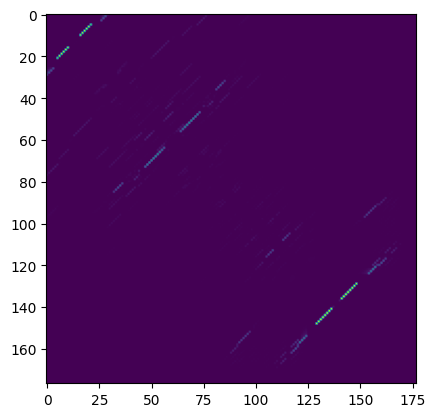

In [51]:
plt.imshow(bbp_matrix_from_numpy(random.choice(list(save_dir.glob('*.npy'))), 177))

PosixPath('/mnt/e22b12fe-f946-49d6-be2c-4bd0bb62c767/slh/rna/eda/bpp/contrafold_2/8620c68e3225.npy')